# Stage 1: Runs + EDA (Gating Screening)

This notebook lets you:
1. Launch the short Stage 1 screening runs (gating variants) with `torchrun`.
2. Parse `experiments/results.csv` and `logs/*.txt`.
3. Plot loss/time and step-time summaries.

> **Safety:** Runs start only if you set `DRY_RUN = False` in the launch cell. Default is safe.

## 0a) (Once per machine) Register and verify venv kernel inside the notebook
If JupyterLab is already running but not using the venv, run the next cell to install the kernel spec, then switch to it via Kernel → Change Kernel → `ese3060 venv`.

In [ ]:
%%bash
source /workspace/ese-3060-project/.venv/bin/activate
python -m ipykernel install --user --name ese3060-venv --display-name "ese3060 venv"
echo "Kernel installed. Switch via Kernel -> Change Kernel -> 'ese3060 venv'"


## 0) Setup
- Assumes repo at `/workspace/ese-3060-project` and data symlinked at `data/fineweb10B`.
- Activate venv before starting JupyterLab: `source .venv/bin/activate`.
- Change `PROJECT_ROOT` below if different.

In [1]:
import os, subprocess, shlex, json, glob, re
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%cd /workspace/ese-3060-project

PROJECT_ROOT = os.environ.get("PROJ_ROOT", "/workspace/ese-3060-project")
SCRIPT = os.path.join(PROJECT_ROOT, "train_gpt.py")
RESULTS_ALL = os.path.join(PROJECT_ROOT, "experiments", "results.csv")
RESULTS = os.path.join(PROJECT_ROOT, "experiments", "results_stage1.csv")
LOG_DIR = os.path.join(PROJECT_ROOT, "logs")
SPLITTER = os.path.join(PROJECT_ROOT, "scripts", "split_results.py")
PROJECT_ROOT, SCRIPT


/workspace/ese-3060-project


('/workspace/ese-3060-project', '/workspace/ese-3060-project/train_gpt.py')

## 1) Launch runs (Stage 1 screening)
Configs: baseline, headwise sigmoid, elementwise sigmoid, headwise ns_sigmoid, const sigmoid (all at SDPA position).

In [2]:
# Runtime knobs
NPROC = None           # set to int to override; otherwise auto-detect GPU count
NUM_ITER = 1500        # screening iterations
VAL_EVERY = 125        # eval cadence
SEEDS = [1337, 1338]   # two seeds per config
DRY_RUN = False         # flip to False to actually launch

CONFIGS = {
    "baseline":  {"ATTNGATE": "none",      "GATEPOS": "sdpa", "GATEACT": "sigmoid"},
    "head_sig":  {"ATTNGATE": "headwise",  "GATEPOS": "sdpa", "GATEACT": "sigmoid"},
    "elem_sig":  {"ATTNGATE": "elementwise","GATEPOS": "sdpa", "GATEACT": "sigmoid"},
    "head_ns":   {"ATTNGATE": "headwise",  "GATEPOS": "sdpa", "GATEACT": "ns_sigmoid"},
    "const_sig": {"ATTNGATE": "const",     "GATEPOS": "sdpa", "GATEACT": "sigmoid"},
}

def detect_gpu_count():
    try:
        import torch
        return torch.cuda.device_count()
    except Exception:
        pass
    try:
        out = subprocess.check_output(["nvidia-smi", "--list-gpus"], text=True)
        return len([l for l in out.splitlines() if l.strip()])
    except Exception:
        return 0

gpu_count = detect_gpu_count()
effective_nproc = NPROC if NPROC is not None else gpu_count
print(f"Detected GPUs: {gpu_count}; using NPROC={effective_nproc}")
if effective_nproc is None or effective_nproc < 1:
    raise SystemExit("No GPUs detected; set NPROC manually if using a custom setup.")
if effective_nproc > gpu_count:
    raise SystemExit(f"Requested NPROC={effective_nproc} exceeds visible GPUs={gpu_count}.")

def run_config(cfg_name, cfg_env, seed, nproc, num_iter, val_every, dry_run=True):
    env = os.environ.copy()
    env.update({
        "SEED": str(seed),
        "NUM_ITER": str(num_iter),
        "VAL_EVERY": str(val_every),
    })
    env.update(cfg_env)
    cmd = ["torchrun", "--standalone", f"--nproc_per_node={nproc}", SCRIPT]
    print(f"[{datetime.utcnow().isoformat()}Z] {cfg_name} seed={seed}")
    print("    env overrides:", json.dumps({k: env[k] for k in ['ATTNGATE','GATEPOS','GATEACT','SEED','NUM_ITER','VAL_EVERY']}, indent=2))
    if dry_run:
        return
    result = subprocess.run(cmd, env=env)
    if result.returncode != 0:
        raise RuntimeError(f"Run failed: {cfg_name}, seed {seed}, rc={result.returncode}")

for cfg_name, cfg_env in CONFIGS.items():
    for seed in SEEDS:
        run_config(cfg_name, cfg_env, seed, effective_nproc, NUM_ITER, VAL_EVERY, dry_run=DRY_RUN)

if not DRY_RUN:
    # Refresh stage-specific result splits
    subprocess.run(["python", SPLITTER], check=False)

print("Done (DRY_RUN=" + str(DRY_RUN) + ")")


Detected GPUs: 8; using NPROC=8
[2025-12-07T09:29:28.860454Z] baseline seed=1337
    env overrides: {
  "ATTNGATE": "none",
  "GATEPOS": "sdpa",
  "GATEACT": "sigmoid",
  "SEED": "1337",
  "NUM_ITER": "1500",
  "VAL_EVERY": "125"
}


/tmp/ipykernel_334/713527513.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"[{datetime.utcnow().isoformat()}Z] {cfg_name} seed={seed}")
W1207 09:29:29.982000 544 torch/distributed/run.py:774] 
W1207 09:29:29.982000 544 torch/distributed/run.py:774] *****************************************
W1207 09:29:29.982000 544 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1207 09:29:29.982000 544 torch/distributed/run.py:774] *****************************************


using device: cuda:6
using device: cuda:0
using device: cuda:3
using device: cuda:1
using device: cuda:2
using device: cuda:5
using device: cuda:4
using device: cuda:7
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
step:0/1500 val_loss:16.0297 train_time:256ms step_avg:nanms
step:1/1500 train_loss:16.0220 train_time:60592ms step_avg:nanms
step:2/1500 train_loss:9.5340 train_time:61997ms step_avg:nanms
step:3/1500 train_loss:8.7953 train_time:62389ms step_avg:nanms
step:4/1500 train_loss:7.9987 train_time:62781ms step_avg:nanms
step:5/1500 train_loss:7.6899 train_time:63172ms step_avg:nanms
step:6/1500 train_loss:7.4977 train_time:63562ms step_avg:nanms
step:7/1500 train_loss:7.3395 train_time:63952ms step_avg:nanms
step:8/1500 train_loss:7.5856 train_time:64343ms step_avg:nanms
step:9/1500 train_loss:7.5276 train_time:64740ms step_avg:nanms
step:10/1500 train_loss:7.1068 train_time:65132ms st

/tmp/ipykernel_334/713527513.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"[{datetime.utcnow().isoformat()}Z] {cfg_name} seed={seed}")


[2025-12-07T09:42:37.126388Z] baseline seed=1338
    env overrides: {
  "ATTNGATE": "none",
  "GATEPOS": "sdpa",
  "GATEACT": "sigmoid",
  "SEED": "1338",
  "NUM_ITER": "1500",
  "VAL_EVERY": "125"
}


W1207 09:42:38.243000 34447 torch/distributed/run.py:774] 
W1207 09:42:38.243000 34447 torch/distributed/run.py:774] *****************************************
W1207 09:42:38.243000 34447 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1207 09:42:38.243000 34447 torch/distributed/run.py:774] *****************************************


using device: cuda:6
using device: cuda:7
using device: cuda:1
using device: cuda:0
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
using device: cuda:2
using device: cuda:3
using device: cuda:4
using device: cuda:5
step:0/1500 val_loss:16.0337 train_time:318ms step_avg:nanms
step:1/1500 train_loss:16.0265 train_time:61761ms step_avg:nanms
step:2/1500 train_loss:9.5093 train_time:62686ms step_avg:nanms
step:3/1500 train_loss:8.6945 train_time:63080ms step_avg:nanms
step:4/1500 train_loss:8.1985 train_time:63476ms step_avg:nanms
step:5/1500 train_loss:7.7558 train_time:63872ms step_avg:nanms
step:6/1500 train_loss:7.7266 train_time:64268ms step_avg:nanms
step:7/1500 train_loss:7.3552 train_time:64662ms step_avg:nanms
step:8/1500 train_loss:7.5132 train_time:65057ms step_avg:nanms
step:9/1500 train_loss:7.2145 train_time:65454ms step_avg:nanms
step:10/1500 train_loss:7.2640 train_time:65840ms st

/tmp/ipykernel_334/713527513.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"[{datetime.utcnow().isoformat()}Z] {cfg_name} seed={seed}")


[2025-12-07T09:55:24.314668Z] head_sig seed=1337
    env overrides: {
  "ATTNGATE": "headwise",
  "GATEPOS": "sdpa",
  "GATEACT": "sigmoid",
  "SEED": "1337",
  "NUM_ITER": "1500",
  "VAL_EVERY": "125"
}


W1207 09:55:25.441000 38138 torch/distributed/run.py:774] 
W1207 09:55:25.441000 38138 torch/distributed/run.py:774] *****************************************
W1207 09:55:25.441000 38138 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1207 09:55:25.441000 38138 torch/distributed/run.py:774] *****************************************


using device: cuda:5
using device: cuda:1
using device: cuda:4
using device: cuda:3
using device: cuda:2
using device: cuda:6
using device: cuda:7
using device: cuda:0
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
step:0/1500 val_loss:15.9616 train_time:329ms step_avg:nanms
step:1/1500 train_loss:15.9512 train_time:69120ms step_avg:nanms
step:2/1500 train_loss:9.5078 train_time:69517ms step_avg:nanms
step:3/1500 train_loss:8.6369 train_time:69919ms step_avg:nanms
step:4/1500 train_loss:7.9071 train_time:70318ms step_avg:nanms
step:5/1500 train_loss:7.5316 train_time:70718ms step_avg:nanms
step:6/1500 train_loss:7.4460 train_time:71120ms step_avg:nanms
step:7/1500 train_loss:7.0815 train_time:71521ms step_avg:nanms
step:8/1500 train_loss:7.3246 train_time:71923ms step_avg:nanms
step:9/1500 train_loss:7.0533 train_time:72323ms step_avg:nanms
step:10/1500 train_loss:6.9158 train_time:72725ms st

/tmp/ipykernel_334/713527513.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"[{datetime.utcnow().isoformat()}Z] {cfg_name} seed={seed}")


[2025-12-07T10:09:03.014316Z] head_sig seed=1338
    env overrides: {
  "ATTNGATE": "headwise",
  "GATEPOS": "sdpa",
  "GATEACT": "sigmoid",
  "SEED": "1338",
  "NUM_ITER": "1500",
  "VAL_EVERY": "125"
}


W1207 10:09:04.129000 58375 torch/distributed/run.py:774] 
W1207 10:09:04.129000 58375 torch/distributed/run.py:774] *****************************************
W1207 10:09:04.129000 58375 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1207 10:09:04.129000 58375 torch/distributed/run.py:774] *****************************************


using device: cuda:7
using device: cuda:3
using device: cuda:2
using device: cuda:6
using device: cuda:1
using device: cuda:4
using device: cuda:0
using device: cuda:5
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
step:0/1500 val_loss:16.0067 train_time:257ms step_avg:nanms
step:1/1500 train_loss:16.0023 train_time:58761ms step_avg:nanms
step:2/1500 train_loss:9.5454 train_time:59596ms step_avg:nanms
step:3/1500 train_loss:8.6436 train_time:60004ms step_avg:nanms
step:4/1500 train_loss:7.8705 train_time:60410ms step_avg:nanms
step:5/1500 train_loss:7.4401 train_time:60820ms step_avg:nanms
step:6/1500 train_loss:7.4007 train_time:61224ms step_avg:nanms
step:7/1500 train_loss:7.0055 train_time:61630ms step_avg:nanms
step:8/1500 train_loss:7.3398 train_time:62037ms step_avg:nanms
step:9/1500 train_loss:7.0441 train_time:62445ms step_avg:nanms
step:10/1500 train_loss:6.8448 train_time:62851ms st

/tmp/ipykernel_334/713527513.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"[{datetime.utcnow().isoformat()}Z] {cfg_name} seed={seed}")


[2025-12-07T10:22:20.851820Z] elem_sig seed=1337
    env overrides: {
  "ATTNGATE": "elementwise",
  "GATEPOS": "sdpa",
  "GATEACT": "sigmoid",
  "SEED": "1337",
  "NUM_ITER": "1500",
  "VAL_EVERY": "125"
}


W1207 10:22:21.971000 62117 torch/distributed/run.py:774] 
W1207 10:22:21.971000 62117 torch/distributed/run.py:774] *****************************************
W1207 10:22:21.971000 62117 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1207 10:22:21.971000 62117 torch/distributed/run.py:774] *****************************************


using device: cuda:4
using device: cuda:3
using device: cuda:7
using device: cuda:5
using device: cuda:1
using device: cuda:0
using device: cuda:6
using device: cuda:2
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
step:0/1500 val_loss:16.0015 train_time:243ms step_avg:nanms
step:1/1500 train_loss:16.0007 train_time:71752ms step_avg:nanms
step:2/1500 train_loss:9.5243 train_time:72634ms step_avg:nanms
step:3/1500 train_loss:8.6020 train_time:73050ms step_avg:nanms
step:4/1500 train_loss:7.8832 train_time:73463ms step_avg:nanms
step:5/1500 train_loss:7.5251 train_time:73878ms step_avg:nanms
step:6/1500 train_loss:7.4784 train_time:74293ms step_avg:nanms
step:7/1500 train_loss:6.9910 train_time:74708ms step_avg:nanms
step:8/1500 train_loss:7.2589 train_time:75122ms step_avg:nanms
step:9/1500 train_loss:7.0517 train_time:75537ms step_avg:nanms
step:10/1500 train_loss:6.8427 train_time:75952ms st

/tmp/ipykernel_334/713527513.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"[{datetime.utcnow().isoformat()}Z] {cfg_name} seed={seed}")


[2025-12-07T10:36:31.640985Z] elem_sig seed=1338
    env overrides: {
  "ATTNGATE": "elementwise",
  "GATEPOS": "sdpa",
  "GATEACT": "sigmoid",
  "SEED": "1338",
  "NUM_ITER": "1500",
  "VAL_EVERY": "125"
}


W1207 10:36:32.771000 106692 torch/distributed/run.py:774] 
W1207 10:36:32.771000 106692 torch/distributed/run.py:774] *****************************************
W1207 10:36:32.771000 106692 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1207 10:36:32.771000 106692 torch/distributed/run.py:774] *****************************************


using device: cuda:7
using device: cuda:0
using device: cuda:3
using device: cuda:6
using device: cuda:1
using device: cuda:4
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
using device: cuda:5
using device: cuda:2
step:0/1500 val_loss:16.0275 train_time:242ms step_avg:nanms
step:1/1500 train_loss:16.0292 train_time:42956ms step_avg:nanms
step:2/1500 train_loss:9.4841 train_time:44313ms step_avg:nanms
step:3/1500 train_loss:8.5955 train_time:44733ms step_avg:nanms
step:4/1500 train_loss:7.9236 train_time:45153ms step_avg:nanms
step:5/1500 train_loss:7.4572 train_time:45576ms step_avg:nanms
step:6/1500 train_loss:7.3256 train_time:45997ms step_avg:nanms
step:7/1500 train_loss:7.0060 train_time:46418ms step_avg:nanms
step:8/1500 train_loss:7.3086 train_time:46842ms step_avg:nanms
step:9/1500 train_loss:7.0514 train_time:47264ms step_avg:nanms
step:10/1500 train_loss:6.8239 train_time:47687ms st

/tmp/ipykernel_334/713527513.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"[{datetime.utcnow().isoformat()}Z] {cfg_name} seed={seed}")


[2025-12-07T10:49:55.826340Z] head_ns seed=1337
    env overrides: {
  "ATTNGATE": "headwise",
  "GATEPOS": "sdpa",
  "GATEACT": "ns_sigmoid",
  "SEED": "1337",
  "NUM_ITER": "1500",
  "VAL_EVERY": "125"
}


W1207 10:49:56.944000 110093 torch/distributed/run.py:774] 
W1207 10:49:56.944000 110093 torch/distributed/run.py:774] *****************************************
W1207 10:49:56.944000 110093 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1207 10:49:56.944000 110093 torch/distributed/run.py:774] *****************************************


using device: cuda:3
using device: cuda:6
using device: cuda:7
using device: cuda:4
using device: cuda:2
using device: cuda:1
using device: cuda:5
using device: cuda:0
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
step:0/1500 val_loss:15.9616 train_time:316ms step_avg:nanms
step:1/1500 train_loss:15.9512 train_time:55876ms step_avg:nanms
step:2/1500 train_loss:9.4974 train_time:57155ms step_avg:nanms
step:3/1500 train_loss:8.6740 train_time:57554ms step_avg:nanms
step:4/1500 train_loss:8.0049 train_time:57956ms step_avg:nanms
step:5/1500 train_loss:7.7112 train_time:58358ms step_avg:nanms
step:6/1500 train_loss:7.6710 train_time:58760ms step_avg:nanms
step:7/1500 train_loss:7.2100 train_time:59161ms step_avg:nanms
step:8/1500 train_loss:7.4305 train_time:59562ms step_avg:nanms
step:9/1500 train_loss:7.1725 train_time:59963ms step_avg:nanms
step:10/1500 train_loss:7.0828 train_time:60367ms st

/tmp/ipykernel_334/713527513.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"[{datetime.utcnow().isoformat()}Z] {cfg_name} seed={seed}")


[2025-12-07T11:03:07.440520Z] head_ns seed=1338
    env overrides: {
  "ATTNGATE": "headwise",
  "GATEPOS": "sdpa",
  "GATEACT": "ns_sigmoid",
  "SEED": "1338",
  "NUM_ITER": "1500",
  "VAL_EVERY": "125"
}


W1207 11:03:08.570000 117359 torch/distributed/run.py:774] 
W1207 11:03:08.570000 117359 torch/distributed/run.py:774] *****************************************
W1207 11:03:08.570000 117359 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1207 11:03:08.570000 117359 torch/distributed/run.py:774] *****************************************


using device: cuda:6
using device: cuda:5
using device: cuda:1
using device: cuda:7
using device: cuda:4
using device: cuda:0
using device: cuda:3
using device: cuda:2
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
step:0/1500 val_loss:16.0067 train_time:322ms step_avg:nanms
step:1/1500 train_loss:16.0023 train_time:52003ms step_avg:nanms
step:2/1500 train_loss:9.5365 train_time:53439ms step_avg:nanms
step:3/1500 train_loss:8.6691 train_time:53847ms step_avg:nanms
step:4/1500 train_loss:7.9095 train_time:54253ms step_avg:nanms
step:5/1500 train_loss:7.4474 train_time:54658ms step_avg:nanms
step:6/1500 train_loss:7.4633 train_time:55062ms step_avg:nanms
step:7/1500 train_loss:7.0805 train_time:55466ms step_avg:nanms
step:8/1500 train_loss:7.4204 train_time:55873ms step_avg:nanms
step:9/1500 train_loss:7.2728 train_time:56280ms step_avg:nanms
step:10/1500 train_loss:6.9806 train_time:56686ms st

/tmp/ipykernel_334/713527513.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"[{datetime.utcnow().isoformat()}Z] {cfg_name} seed={seed}")


[2025-12-07T11:16:16.050362Z] const_sig seed=1337
    env overrides: {
  "ATTNGATE": "const",
  "GATEPOS": "sdpa",
  "GATEACT": "sigmoid",
  "SEED": "1337",
  "NUM_ITER": "1500",
  "VAL_EVERY": "125"
}


W1207 11:16:17.166000 119910 torch/distributed/run.py:774] 
W1207 11:16:17.166000 119910 torch/distributed/run.py:774] *****************************************
W1207 11:16:17.166000 119910 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1207 11:16:17.166000 119910 torch/distributed/run.py:774] *****************************************


using device: cuda:1
using device: cuda:2
using device: cuda:4
using device: cuda:5
using device: cuda:6
using device: cuda:3
using device: cuda:0
using device: cuda:7
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
step:0/1500 val_loss:16.0297 train_time:248ms step_avg:nanms
step:1/1500 train_loss:16.0220 train_time:73794ms step_avg:nanms
step:2/1500 train_loss:9.5438 train_time:74853ms step_avg:nanms
step:3/1500 train_loss:8.6689 train_time:75249ms step_avg:nanms
step:4/1500 train_loss:7.8945 train_time:75647ms step_avg:nanms
step:5/1500 train_loss:7.3973 train_time:76045ms step_avg:nanms
step:6/1500 train_loss:7.4058 train_time:76444ms step_avg:nanms
step:7/1500 train_loss:7.1589 train_time:76841ms step_avg:nanms
step:8/1500 train_loss:7.3413 train_time:77238ms step_avg:nanms
step:9/1500 train_loss:7.0757 train_time:77636ms step_avg:nanms
step:10/1500 train_loss:6.8614 train_time:78036ms st

/tmp/ipykernel_334/713527513.py:45: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"[{datetime.utcnow().isoformat()}Z] {cfg_name} seed={seed}")


[2025-12-07T11:29:38.460851Z] const_sig seed=1338
    env overrides: {
  "ATTNGATE": "const",
  "GATEPOS": "sdpa",
  "GATEACT": "sigmoid",
  "SEED": "1338",
  "NUM_ITER": "1500",
  "VAL_EVERY": "125"
}


W1207 11:29:39.577000 136225 torch/distributed/run.py:774] 
W1207 11:29:39.577000 136225 torch/distributed/run.py:774] *****************************************
W1207 11:29:39.577000 136225 torch/distributed/run.py:774] Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed. 
W1207 11:29:39.577000 136225 torch/distributed/run.py:774] *****************************************


using device: cuda:6
using device: cuda:3
using device: cuda:7
using device: cuda:0
using device: cuda:2
using device: cuda:4
using device: cuda:5
using device: cuda:1
Training DataLoader: total number of tokens: 900000000 across 9 files
Validation DataLoader: total number of tokens: 100000000 across 1 files
step:0/1500 val_loss:16.0337 train_time:234ms step_avg:nanms
step:1/1500 train_loss:16.0265 train_time:59243ms step_avg:nanms
step:2/1500 train_loss:9.5163 train_time:60028ms step_avg:nanms
step:3/1500 train_loss:8.6149 train_time:60435ms step_avg:nanms
step:4/1500 train_loss:7.9971 train_time:60842ms step_avg:nanms
step:5/1500 train_loss:7.5456 train_time:61251ms step_avg:nanms
step:6/1500 train_loss:7.4138 train_time:61657ms step_avg:nanms
step:7/1500 train_loss:7.0954 train_time:62066ms step_avg:nanms
step:8/1500 train_loss:7.3922 train_time:62473ms step_avg:nanms
step:9/1500 train_loss:7.0720 train_time:62880ms step_avg:nanms
step:10/1500 train_loss:6.9449 train_time:63287ms st

## 2) Load results and logs
Run after some jobs complete. If `experiments/results.csv` doesn’t exist yet, create an empty DataFrame.

In [3]:
if os.path.exists(RESULTS):
    df = pd.read_csv(RESULTS)
elif os.path.exists(RESULTS_ALL):
    df = pd.read_csv(RESULTS_ALL)
else:
    df = pd.DataFrame()
df.head() if not df.empty else df


,run_id,date,git_commit,seed,attn_gate,gate_pos,gate_act,learning_rate,batch_size,device_batch_size,...,num_iterations,warmdown_iters,final_val_loss,best_val_loss,train_time_ms,ms_per_step,gpu_name,n_gpus,runpod_instance,notes
0,f1a4d6bb-348b-4783-8bbf-52e0c71e71e0,2025-12-07 09:42:24,21aae13b20675947154a15b640706eb3a47e5fcd,1337,none,sdpa,sigmoid,0.0036,512,64,...,1500,1450,3.533581,3.533581,593163.228989,397.829127,NVIDIA A100 80GB PCIe,8,unknown,NaN
1,e3a7db34-8900-408e-9be9-7651dab150ce,2025-12-07 09:55:12,21aae13b20675947154a15b640706eb3a47e5fcd,1338,none,sdpa,sigmoid,0.0036,512,64,...,1500,1450,3.533149,3.533149,592636.538506,397.475881,NVIDIA A100 80GB PCIe,8,unknown,NaN
2,02f2de8a-3f1e-4941-97b6-fdd9a61c21b1,2025-12-07 10:08:50,21aae13b20675947154a15b640706eb3a47e5fcd,1337,headwise,sdpa,sigmoid,0.0036,512,64,...,1500,1450,3.531132,3.531132,616917.419434,413.760845,NVIDIA A100 80GB PCIe,8,unknown,NaN
3,ee4336d9-19cb-4f01-acb6-7408e5888499,2025-12-07 10:22:08,21aae13b20675947154a15b640706eb3a47e5fcd,1338,headwise,sdpa,sigmoid,0.0036,512,64,...,1500,1450,3.531181,3.531181,614547.306776,412.171232,NVIDIA A100 80GB PCIe,8,unknown,NaN
4,e4c15308-00ba-4a79-bb37-4694c599046c,2025-12-07 10:36:18,21aae13b20675947154a15b640706eb3a47e5fcd,1337,elementwise,sdpa,sigmoid,0.0036,512,64,...,1500,1450,3.516514,3.516514,626626.270294,420.272482,NVIDIA A100 80GB PCIe,8,unknown,NaN


### Filter to Stage 1 runs (short num_iterations)

In [4]:
stage1 = df[df.get("num_iterations", pd.Series([0]*len(df))) <= 2000].copy()
stage1.head()

,run_id,date,git_commit,seed,attn_gate,gate_pos,gate_act,learning_rate,batch_size,device_batch_size,...,num_iterations,warmdown_iters,final_val_loss,best_val_loss,train_time_ms,ms_per_step,gpu_name,n_gpus,runpod_instance,notes
0,f1a4d6bb-348b-4783-8bbf-52e0c71e71e0,2025-12-07 09:42:24,21aae13b20675947154a15b640706eb3a47e5fcd,1337,none,sdpa,sigmoid,0.0036,512,64,...,1500,1450,3.533581,3.533581,593163.228989,397.829127,NVIDIA A100 80GB PCIe,8,unknown,NaN
1,e3a7db34-8900-408e-9be9-7651dab150ce,2025-12-07 09:55:12,21aae13b20675947154a15b640706eb3a47e5fcd,1338,none,sdpa,sigmoid,0.0036,512,64,...,1500,1450,3.533149,3.533149,592636.538506,397.475881,NVIDIA A100 80GB PCIe,8,unknown,NaN
2,02f2de8a-3f1e-4941-97b6-fdd9a61c21b1,2025-12-07 10:08:50,21aae13b20675947154a15b640706eb3a47e5fcd,1337,headwise,sdpa,sigmoid,0.0036,512,64,...,1500,1450,3.531132,3.531132,616917.419434,413.760845,NVIDIA A100 80GB PCIe,8,unknown,NaN
3,ee4336d9-19cb-4f01-acb6-7408e5888499,2025-12-07 10:22:08,21aae13b20675947154a15b640706eb3a47e5fcd,1338,headwise,sdpa,sigmoid,0.0036,512,64,...,1500,1450,3.531181,3.531181,614547.306776,412.171232,NVIDIA A100 80GB PCIe,8,unknown,NaN
4,e4c15308-00ba-4a79-bb37-4694c599046c,2025-12-07 10:36:18,21aae13b20675947154a15b640706eb3a47e5fcd,1337,elementwise,sdpa,sigmoid,0.0036,512,64,...,1500,1450,3.516514,3.516514,626626.270294,420.272482,NVIDIA A100 80GB PCIe,8,unknown,NaN


### Aggregate metrics by config

In [5]:
if not stage1.empty:
    group_cols = ["attn_gate", "gate_act", "gate_pos"]
    agg = stage1.groupby(group_cols).agg(
        runs=("run_id", "count"),
        mean_final_val=("final_val_loss", "mean"),
        std_final_val=("final_val_loss", "std"),
        mean_best_val=("best_val_loss", "mean"),
        mean_ms_step=("ms_per_step", "mean"),
    ).reset_index()
    agg
else:
    agg = pd.DataFrame()
    agg

### Plots: best val loss and step time

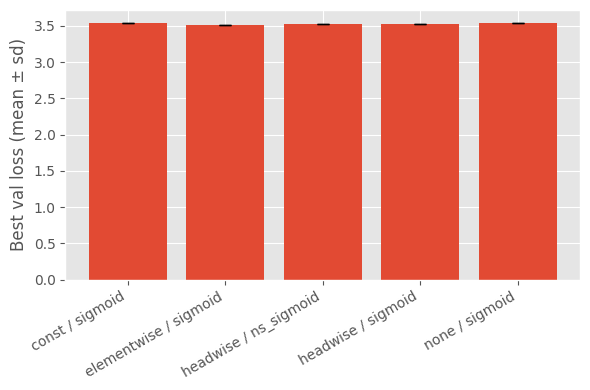

In [6]:
if not agg.empty:
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(agg.index, agg["mean_best_val"], yerr=agg["std_final_val"], capsize=4)
    ax.set_xticks(agg.index)
    ax.set_xticklabels(agg[["attn_gate","gate_act"]].agg(' / '.join, axis=1), rotation=30, ha='right')
    ax.set_ylabel("Best val loss (mean ± sd)")
    plt.tight_layout()
else:
    print("No data to plot yet.")

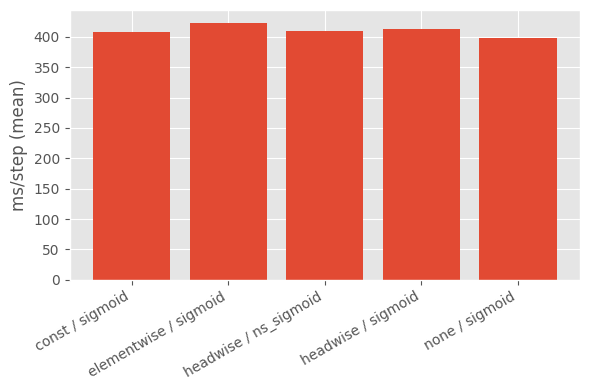

In [7]:
if not agg.empty:
    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(agg.index, agg["mean_ms_step"])
    ax.set_xticks(agg.index)
    ax.set_xticklabels(agg[["attn_gate","gate_act"]].agg(' / '.join, axis=1), rotation=30, ha='right')
    ax.set_ylabel("ms/step (mean)")
    plt.tight_layout()
else:
    print("No data to plot yet.")

### Parse val_loss curves from logs and plot val_loss vs train_time
Uses the first run per config for a quick visual.

In [8]:
VAL_RE = re.compile(r"step:(\d+)/(\d+) val_loss:([0-9.]+) train_time:(\d+)ms")

def parse_log(path):
    rows = []
    for line in open(path):
        m = VAL_RE.search(line)
        if m:
            step = int(m.group(1)); total = int(m.group(2))
            vloss = float(m.group(3)); t_ms = int(m.group(4))
            rows.append((step, total, vloss, t_ms))
    return rows

log_rows = []
for path in glob.glob(os.path.join(LOG_DIR, "*.txt")):
    rid = os.path.basename(path).replace('.txt','')
    rows = parse_log(path)
    for step, total, vloss, t_ms in rows:
        log_rows.append({"run_id": rid, "step": step, "total": total, "val_loss": vloss, "train_time_ms": t_ms})

log_df = pd.DataFrame(log_rows)
log_df.head() if not log_df.empty else log_df

,run_id,step,total,val_loss,train_time_ms
0,65defb38-096a-467c-b356-4cad192f64c1,0,1500,16.0337,234
1,65defb38-096a-467c-b356-4cad192f64c1,125,1500,4.9427,47073
2,65defb38-096a-467c-b356-4cad192f64c1,250,1500,4.3777,99137
3,65defb38-096a-467c-b356-4cad192f64c1,375,1500,4.0589,150249
4,65defb38-096a-467c-b356-4cad192f64c1,500,1500,3.9101,202049


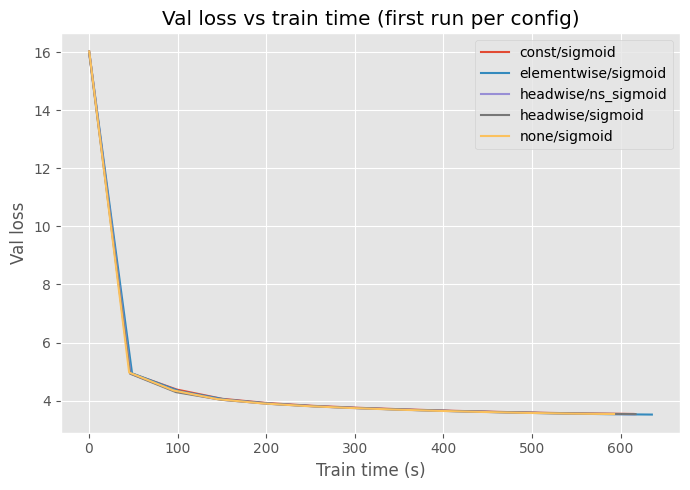

In [9]:
if not log_df.empty and not df.empty:
    curves = log_df.merge(df[["run_id","attn_gate","gate_act","gate_pos"]], on="run_id", how="left")
    # pick first run per config for plotting
    first_runs = curves.groupby(["attn_gate","gate_act","gate_pos"])['run_id'].transform('min') == curves['run_id']
    plot_df = curves[first_runs]

    fig, ax = plt.subplots(figsize=(7,5))
    for (gate, act, pos), sub in plot_df.groupby(["attn_gate","gate_act","gate_pos"]):
        ax.plot(sub["train_time_ms"]/1000.0, sub["val_loss"], label=f"{gate}/{act}")
    ax.set_xlabel("Train time (s)")
    ax.set_ylabel("Val loss")
    ax.set_title("Val loss vs train time (first run per config)")
    ax.legend()
    plt.tight_layout()
else:
    print("No curves to plot yet.")